### Como obter o maior valor de Resistência específica a partir de dados de composição química?

usar o minimize para obter os melhores parâmetros (composição química).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow
from tensorflow import keras

In [3]:
df = pd.read_csv("full_mec.csv")
df.columns

Index(['Alloy', 'Nome tratado', 'Co', 'Fe', 'Ni', 'Si', 'Al', 'Cr', 'Mo', 'Nb',
       'Ti', 'C', 'V', 'Zr', 'Mn', 'Cu', 'B', 'Y', 'Sn', 'Li', 'Mg', 'Zn',
       'Sc', 'Hf', 'Ta', 'W', 'atomic radius (δ) [%]',
       'Electronegativity (Δχ)', 'Valence Electron Concentration (VEC)',
       'Ω parameter', 'Entalpia de mix (dHmix) [kJ/mol]',
       'Entropia de mix (dSmix) [J/K.mol]', 'Melting temperature (Tm) [K]',
       'Elastic-strain energy criterion (dHel) [kJ/mol]', 'Type of phases',
       'As cast/Homogenized right after casting', 'Cold/Hot Working',
       'Heat treatment', 'temperatura de pico [°C]', 'density ROM (g/cm3)',
       'HV', 'YS (MPa)', 'Specific_strength (MPa.cm3/g)'],
      dtype='object')

#### Dropar features
Manter somente composição química e alguns processos experimentais

In [4]:
df.drop(["Alloy", "Nome tratado", 'Type of phases', 'atomic radius (δ) [%]',
       'Electronegativity (Δχ)', 'Valence Electron Concentration (VEC)',
       'Ω parameter', 'Entalpia de mix (dHmix) [kJ/mol]',
       'Entropia de mix (dSmix) [J/K.mol]', 'Melting temperature (Tm) [K]',
       'Elastic-strain energy criterion (dHel) [kJ/mol]', 'density ROM (g/cm3)',
       'HV', 'YS (MPa)','temperatura de pico [°C]'], axis= 1, inplace= True)
df.dropna(inplace= True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790 entries, 0 to 1216
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Co                                       790 non-null    float64
 1   Fe                                       790 non-null    float64
 2   Ni                                       790 non-null    float64
 3   Si                                       790 non-null    float64
 4   Al                                       790 non-null    float64
 5   Cr                                       790 non-null    float64
 6   Mo                                       790 non-null    float64
 7   Nb                                       790 non-null    float64
 8   Ti                                       790 non-null    float64
 9   C                                        790 non-null    float64
 10  V                                        790 non-

In [6]:
X = df.drop("Specific_strength (MPa.cm3/g)", axis= 1)
y = df["Specific_strength (MPa.cm3/g)"].copy()

In [75]:
# Split
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size= 0.2)

In [76]:
# Preprocessamento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Separar dados categóricos de numéricos
cat_att = X.select_dtypes("object").columns
num_att = X.select_dtypes("number").columns

# Pipeline
full_pipeline = ColumnTransformer([("cat", OneHotEncoder(handle_unknown= "ignore"), cat_att),
                                   ("num", StandardScaler(), num_att)])

# Preprocessing
X_prep_test = full_pipeline.fit_transform(X_test)
X_prep_train_full = full_pipeline.fit_transform(X_train_full)

In [77]:
# Modelo
input_ = keras.layers.Input(shape= X_prep_train_full.shape[1:])
hidden = keras.layers.Dense(300, activation= "sigmoid")(input_)
output = keras.layers.Dense(1)(hidden)
model = keras.Model(inputs= input_, outputs= output)

In [78]:
# Compile
optimizer = keras.optimizers.Adam(learning_rate= 0.01)
model.compile(optimizer= optimizer, loss= "mse", metrics= "mse")

Fold 1


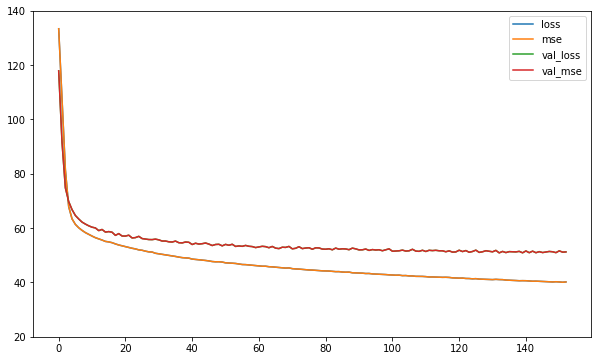

4/4 [==============================] - 0s 2ms/step - loss: 2624.8879 - mse: 2624.8879
Fold 2


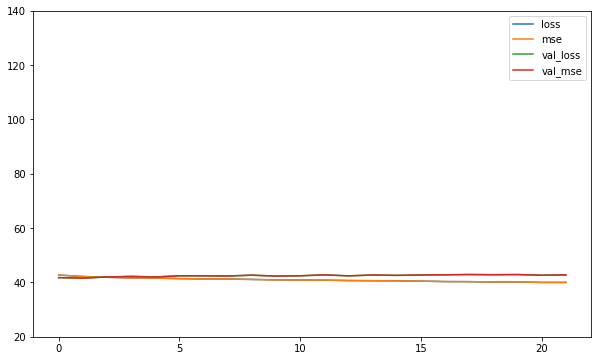

4/4 [==============================] - 0s 2ms/step - loss: 1829.0549 - mse: 1829.0549
Fold 3


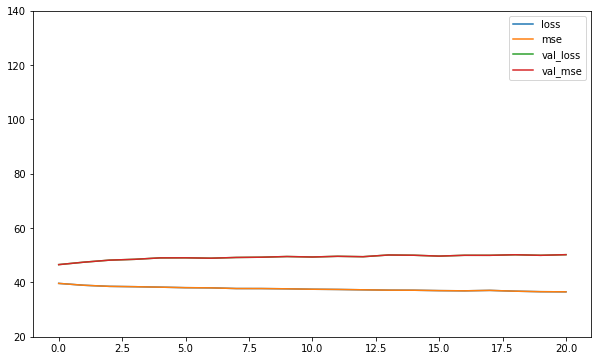

4/4 [==============================] - 0s 2ms/step - loss: 2521.7622 - mse: 2521.7622
Fold 4


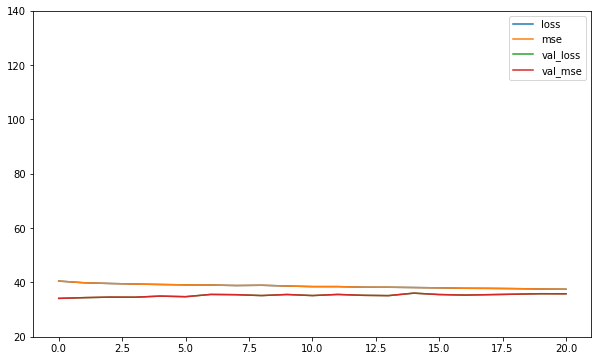

4/4 [==============================] - 0s 2ms/step - loss: 1283.1072 - mse: 1283.1072
Fold 5


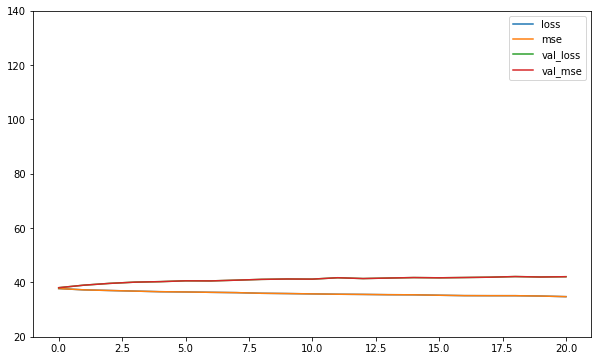

4/4 [==============================] - 0s 2ms/step - loss: 1773.3240 - mse: 1773.3240


In [79]:
# cross validation
from sklearn.model_selection import KFold

# 5 fold
kf = KFold(n_splits= 5, shuffle= True)

# callbacks
es = keras.callbacks.EarlyStopping(patience= 20)

# Reset index
X_train_full_index = X_train_full.reset_index(drop= True)
y_train_full_index = y_train_full.reset_index(drop= True)

# Armazenar mse
rmse_list = []

# Contagem de folds
i = 1
for train_index, val_index in kf.split(X_train_full_index):
    # 1 fold de cada vez
    X_train, X_val = X_train_full_index.iloc[train_index], X_train_full_index.iloc[val_index]
    y_train, y_val = y_train_full_index.iloc[train_index], y_train_full_index.iloc[val_index]
    
    # Preprocessar os dados de input
    X_prep_train = full_pipeline.fit_transform(X_train)
    X_prep_val = full_pipeline.fit_transform(X_val)
    
    # treinar modelo
    print(f"Fold {i}")
    history = model.fit(X_prep_train, y_train, epochs= 300, callbacks= es, validation_data = [X_prep_val, y_val], verbose = 0)
    
    # Gráfico
    pd.DataFrame(history.history).apply(lambda x: np.sqrt(x)).plot(figsize= (10,6))
    plt.ylim(20,140)
    plt.show()
    
    # Avaliar com os dados de validação
    _, mse = model.evaluate(X_prep_val, y_val)
    rmse_list.append(np.sqrt(mse))
    
    i+= 1

In [80]:
# RMSE
print(rmse_list)
print(f"{round(np.mean(rmse_list),2)} \u00b1 {round(np.std(rmse_list),2)}")

[51.23366021916768, 42.76745177866721, 50.21715052679961, 35.82048544805577, 42.110853406329525]
44.43 ± 5.69


In [81]:
# Evaluate
np.sqrt(model.evaluate(X_prep_test, y_test))

5/5 [==============================] - 0s 1ms/step - loss: 2076.0347 - mse: 2076.0347


array([45.56352344, 45.56352344])

In [82]:
y_pred = model.predict(X_prep_test)
pd.DataFrame({"y_pred": y_pred[0:10].flatten(), "y_test": y_test[0:10]})

5/5 [==============================] - 0s 2ms/step


,y_pred,y_test
1033,52.458427,31.184194
656,73.823502,157.922173
305,143.857742,155.379224
1045,177.611115,48.893695
928,127.117104,183.783238
765,221.136459,195.287679
310,114.800911,199.372534
684,65.651215,142.941524
494,38.868076,28.603405
602,134.471176,147.128144


````python
model.save("NN_CV5_mapping_model.h5")
````

````python
model_saved = keras.models.load_model("NN_CV5_mapping_model.h5")
````

In [83]:
features = full_pipeline.get_feature_names_out(X.columns)
feat = pd.DataFrame({"feat": features})
elementos = ['Co', 'Fe', 'Ni', 'Si', 'Al', 'Cr', 'Mo', 'Nb', 'Ti', 'C', 'V', 'Zr', 'Mn', 'Cu', 'B', 'Y', 'Sn', 'Li', 'Mg', 'Zn', 'Sc', 'Hf', 'Ta', 'W']

In [100]:
from scipy.optimize import minimize, differential_evolution

# Limites
limites = [(0, 0)]*len(features) # iniciar todos os limitantes para 0
limites[0] = (1, 1) # As cast
limites[1] = (0, 0) # Homogenized
limites[2] = (0, 0) # Cold Working
limites[3] = (0, 0) # Hot Working
limites[4] = (1, 1) # No Working
limites[5] = (0, 0) # Heat Treated
limites[6] = (1, 1) # No Heat Treatment
# Elementos 7-30
limites[7] = (0.2, 0.5) # Co
limites[8] = (0.3, 0.5) # Fe
limites[9] = (0.2, 0.5) # Ni
limites[10] = (0.2, 0.5) # Si
limites[11] = (0.2, 0.5) # Al
limites[12] = (0, 0) # Cr
limites[13] = (0, 0.5) # Mo
limites[14] = (0, 0) # Nb
limites[15] = (0, 0) # Ti
limites[16] = (0, 0) # C
limites[17] = (0, 0) # V
limites[18] = (0, 0) # Zr
limites[19] = (0, 0) # Mn
limites[20] = (0, 0) # Cu
limites[21] = (0, 0) # B
limites[22] = (0, 0) # Y
limites[23] = (0, 0) # Sn
limites[24] = (0, 0) # Li
limites[25] = (0, 0) # Mg
limites[26] = (0, 0) # Zn
limites[27] = (0, 0) # Sc
limites[28] = (0, 0) # Hf
limites[29] = (0, 0) # Ta
limites[30] = (0, 0) # W

# Constrains
def constraint(x): 
    return np.isclose(np.sum(x[7:]),1) - 1

# Função objetivo (negativa para maximização)
def objective(x):
    x = np.array(x).reshape(1, -1)  # Converter para formato esperado pelo modelo
    return -model.predict(x)[0, 0]  # Negativo para maximizar

# Ponto inicial (qualquer ponto dentro dos limites que soma 1)
x0 = np.random.rand(len(limites))
x0 = x0 / np.sum(x0)  # Normaliza para que a soma seja 1

# Resolver o problema de otimização
result = minimize(
    objective, 
    x0, 
    method='SLSQP', 
    bounds=limites,
    constraints={'type': 'eq', 'fun': constraint}
)

# Resultado final
composicao_otima = result.x
valor_maximo = -result.fun  # Reverter a negação

print("Composição ótima:", composicao_otima)
print("Valor máximo previsto de Resistência Específica:", valor_maximo)

1/1 [==============================] - 0s 15ms/step
Composição ótima: [1.         0.         0.         0.         1.         0.
 1.         0.2        0.3        0.2        0.2        0.2
 0.         0.00392784 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Valor máximo previsto de Resistência Específica: 171.7104034423828


In [101]:
input_ = np.round(result.x, 2)
np.sum(input_[7:])
# Esse valor precisa estar próximo de 1

1.1

In [102]:
input_ = np.round(result.x, 2)
np.sum(input_[7:])
100*input_[7:]/np.sum(input_[7:])

array([18.18181818, 27.27272727, 18.18181818, 18.18181818, 18.18181818,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [103]:
comp_df = pd.DataFrame({"Elementos": elementos, "Comp": 100*input_[7:]/np.sum(input_[7:])})
comp_df

,Elementos,Comp
0,Co,18.181818
1,Fe,27.272727
2,Ni,18.181818
3,Si,18.181818
4,Al,18.181818
5,Cr,0.000000
6,Mo,0.000000
7,Nb,0.000000
8,Ti,0.000000
9,C,0.000000
